In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [3]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 1, 15))
train_y = Variable(torch.sign(torch.cos(train_x.data * (2 * math.pi))))

In [4]:
train_y

Variable containing:
 1
 1
 1
 1
-1
-1
-1
-1
-1
-1
-1
 1
 1
 1
 1
[torch.FloatTensor of size 15]

In [5]:
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood, BernoulliLikelihood
from gpytorch import ObservationModel
from gpytorch.random_variables import GaussianRandomVariable
from gpytorch.parameters import MLEParameterGroup
from torch.nn import Parameter

In [6]:
class GPClassificationModel(gpytorch.ObservationModel):
    def __init__(self):
        super(GPClassificationModel,self).__init__(BernoulliLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = RBFKernel()
        self.params = MLEParameterGroup(
            log_lengthscale=Parameter(torch.Tensor([math.log(0.1)])),
            log_outputscale=Parameter(torch.Tensor([-1])),
        )
    
    def forward(self,x):
        mean_x = self.mean_module(x, constant=Variable(torch.Tensor([0])))
        covar_x = self.covar_module(x, log_lengthscale=self.params.log_lengthscale)
        covar_x = covar_x.mul(self.params.log_outputscale.exp().expand_as(covar_x))
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        return latent_pred

prior_observation_model = GPClassificationModel()

In [7]:
def plot_model_and_predictions(observation_model):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    test_x = Variable(torch.linspace(0, 1, 51))
    observed_pred = observation_model(test_x)

    def ax_plot(ax, rand_var, title):
        pred_probs = rand_var.mean()
        pred_labels = rand_var.mean().ge(0.5).float().mul(2).sub(1)
        ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
        ax.plot(test_x.data.numpy(), pred_labels.data.numpy(), 'b')
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean'])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

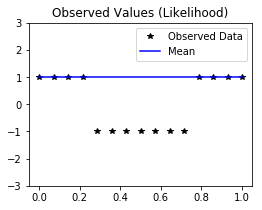

In [15]:
f = plot_model_and_predictions(prior_observation_model)

In [12]:
from gpytorch.inference import Inference
import cProfile

def log_function(loss, optimizer, observation_model):
    return 'Iter: %02d, Loss: %.3f' % (optimizer.n_iter, loss.data[0])

infer = Inference(prior_observation_model)
#cProfile.run("posterior_observation_model = infer.run(train_x, train_y,max_inference_steps=100)")
posterior_observation_model = infer.run(train_x, train_y,max_inference_steps=100)

0 Variable containing:
1.00000e+05 *
 -3.2827
[torch.FloatTensor of size 1]

1 Variable containing:
-27.6063
[torch.FloatTensor of size 1]

2 Variable containing:
-22.5587
[torch.FloatTensor of size 1]

3 Variable containing:
-23.2287
[torch.FloatTensor of size 1]

4 Variable containing:
-21.9239
[torch.FloatTensor of size 1]

5 Variable containing:
-13.3603
[torch.FloatTensor of size 1]

6 Variable containing:
-15.0651
[torch.FloatTensor of size 1]

7 Variable containing:
-19.8645
[torch.FloatTensor of size 1]

8 Variable containing:
-17.8620
[torch.FloatTensor of size 1]

9 Variable containing:
-13.0759
[torch.FloatTensor of size 1]

10 Variable containing:
-15.3675
[torch.FloatTensor of size 1]

11 Variable containing:
-18.2372
[torch.FloatTensor of size 1]

12 Variable containing:
-15.0620
[torch.FloatTensor of size 1]

13 Variable containing:
-12.0876
[torch.FloatTensor of size 1]

14 Variable containing:
-11.9712
[torch.FloatTensor of size 1]

15 Variable containing:
-24.2417
[to

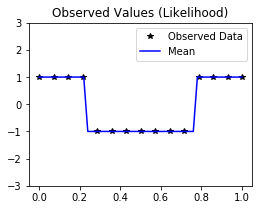

In [16]:
f = plot_model_and_predictions(posterior_observation_model)

In [11]:
posterior_observation_model.variational_parameters.variational_mean

Parameter containing:
 0.5396
 0.5769
 0.4825
 0.2549
-0.0584
-0.3814
-0.6392
-0.7790
-0.7749
-0.6263
-0.3620
-0.0435
 0.2447
 0.4285
 0.4770
[torch.FloatTensor of size 15]